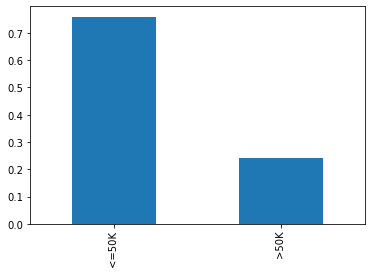

Random Forest 1st Pass Test Score:  0.8163672654690619


<Figure size 432x288 with 0 Axes>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('adult.csv', header=None, names = col_names)

#Distribution of income
df['income'].value_counts(normalize= True).plot(kind = 'bar')
plt.show()
plt.clf()

#Clean columns by stripping extra whitespace for columns of type "object"
for col in df.select_dtypes(include= ['object']).columns:
    df[col] = df[col].str.strip()

#Create feature dataframe X with feature columns and dummy variables for categorical features
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race']
x = pd.get_dummies(df[feature_cols], drop_first=True)

#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greather than 50k
y = df['income'].replace(['<=50K', '>50K'], [0,1])
#print(y)

#Split data into a train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)

#Instantiate random forest classifier, fit and score with default parameters
rand_forest = RandomForestClassifier(random_state= 69)
rand_forest.fit(x_train, y_train)
print('Random Forest 1st Pass Test Score: ' , rand_forest.score(x_test, y_test))

Best Train accuracy:  0.8621391277641277 Max depth:  24
Best Test accuracy:  0.8272685398433901 Max depth:  13


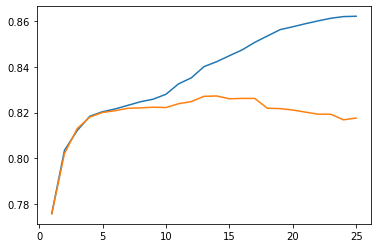

                         Feature Importance
capital-gain                      31.956267
age                               28.277593
hours-per-week                    16.102560
capital-loss                      12.716154
sex_Male                           8.256799
race_White                         0.885161
race_Black                         0.820680
race_Asian-Pac-Islander            0.703278
race_Other                         0.281508


In [10]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
accuracy_train = []
accuracy_test = []

for depth in range(1,26):
    rand_forest_tune = RandomForestClassifier(max_depth= depth, random_state= 69)
    rand_forest_tune.fit(x_train, y_train)
    accuracy_train.append(rand_forest_tune.score(x_train, y_train))
    accuracy_test.append(rand_forest_tune.score(x_test, y_test))
    
#Find the best accuracy and at what depth that occurs
print('Best Train accuracy: ', max(accuracy_train), 'Max depth: ', np.argmax(accuracy_train))
print('Best Test accuracy: ', max(accuracy_test), 'Max depth: ', np.argmax(accuracy_test))

#Plot the accuracy scores for the test and train set over the range of depth values  
plt.plot(range(1,26), accuracy_train)
plt.plot(range(1,26), accuracy_test)
plt.show()

#Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=np.argmax(accuracy_test))
best_rf.fit(x_test, y_test)
feature_importances = pd.DataFrame(best_rf.feature_importances_, index= best_rf.feature_names_in_, columns=['Feature Importance'])
print(feature_importances.sort_values(['Feature Importance'], ascending=False)*100)

Best Train accuracy:  0.8927748771498771 Max depth:  24
Best Test accuracy:  0.8430830646399509 Max depth:  14


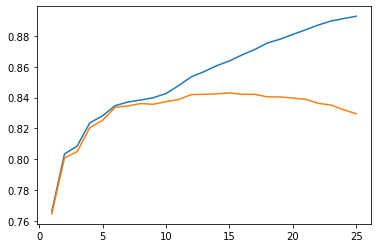

                                    Feature Importance
age                                          29.775224
capital-gain                                 22.987283
hours-per-week                               17.291387
capital-loss                                  8.641577
education_bin_Masters or more                 7.981734
sex_Male                                      5.910856
education_bin_College to Bachelors            3.700539
Region_North America                          0.765396
race_White                                    0.724774
race_Black                                    0.557809
Region_Europe                                 0.387675
Region_South/Latin America                    0.359306
Region_Asia                                   0.343993
race_Asian-Pac-Islander                       0.317100
race_Other                                    0.141973
Region_Africa                                 0.113375


In [11]:
#Create two new features, based on education and native country
df['education_bin'] = pd.cut(df['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])

#print(df['native-country'].value_counts())
countries_dict = {
    'Europe':['Germany', 'England', 'Italy', 'Poland', 'Portugal', 'France', 'Greece', 'Ireland', 'Yugoslavia', 'Hungary', 'Scotland', 'Holand-Netherlands'],
    'North America':['United-States', 'Mexico', 'Canada', 'Puerto-Rico', 'Outlying-US(Guam-USVI-etc)'],
    'South/Latin America':['El-Salvador', 'Cuba', 'Jamaica', 'Dominican-Republic', 'Guatemala', 'Columbia', 'Haiti', 'Nicaragua', 'Peru', 'Ecuador', 'Trinadad&Tobago', 'Honduras'],
    'Asia':['Phillipines', 'India', 'China', 'Vitenam', 'Japan', 'Taiwan', 'Iran', 'Hong', 'Cambodia', 'Laos', 'Thailand'],
    'Africa':['South'],
    'Oceania':[],
    '?':['?']
}
d1 = {k: oldk for oldk, oldv in countries_dict.items() for k in oldv}
df['Region'] = df['native-country'].map(d1)
#print(df['education_bin'], df['Region'])

feature_cols = ['age','capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin','Region']
#Use these two new additional features and recreate X and test/train split
x = pd.get_dummies(df[feature_cols], drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2)

#Find the best max depth now with the additional two features
train_scores = []
test_scores = []
for i in range(1, 26):
    rf_plus2 = RandomForestClassifier(max_depth= i, random_state= 69)
    rf_plus2.fit(x_train, y_train)
    train_scores.append(rf_plus2.score(x_train, y_train))
    test_scores.append(rf_plus2.score(x_test, y_test))

#Save the best model and print the two features with the new feature set
print('Best Train accuracy: ', max(train_scores), 'Max depth: ', np.argmax(train_scores))
print('Best Test accuracy: ', max(test_scores), 'Max depth: ', np.argmax(test_scores))
plt.plot(range(1,26), train_scores)
plt.plot(range(1,26), test_scores)
plt.show()

feature_importances_plus2 = pd.DataFrame(rf_plus2.feature_importances_, index= rf_plus2.feature_names_in_, columns=['Feature Importance'])
print(feature_importances_plus2.sort_values(['Feature Importance'], ascending=False)*100)